# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека. Имеется набор фотографий людей с указанием возраста.

Задачи:
- провести исследовательский анализ набора фотографий;
- подготовить данные к обучению;
- обучить нейронную сеть и рассчитать её качество.

# Исследовательский анализ данных

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image
import matplotlib.pyplot as plt

Загрузка датафрейма и получение информации о данных:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В датафрейме два столбца:
- **file_name** — название файла с фотографией;
- **real_age** — возраст человека на фотографии.
Всего 7 591 запись, пропусков нет.

Рассмотрим столбец с возрастом людей:

In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

На фотографиях изображены люди с возрастом от 1 до 100 лет. Среднее значение - 31 год, медианное - 29 лет. Среднеквадратическое отклонение составляет 17 лет.

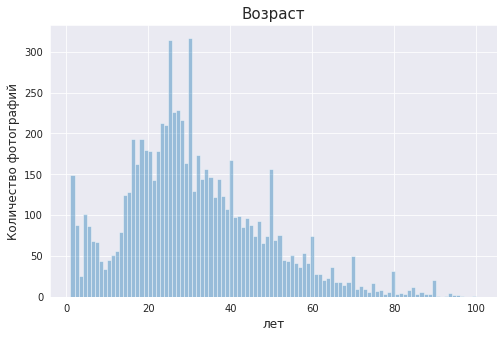

In [7]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(labels['real_age'], kde = False, bins = 100)
fig.set_title("Возраст", fontsize = 15)
fig.set_xlabel("лет", fontsize = 12)
fig.set_ylabel("Количество фотографий", fontsize = 12)

plt.show()

Распределение скошено вправо.
На значениях возраста, кратных десяти, достигаются локальные максимумы, что хорошо заметно на графике, начиная с отметки в 30 лет. Возможно, для части загруженных фотографий точный возраст был неизвестен, а указывался приблизительно.

Выведем несколько изображений:

In [8]:
features, target = next(train_gen_flow)

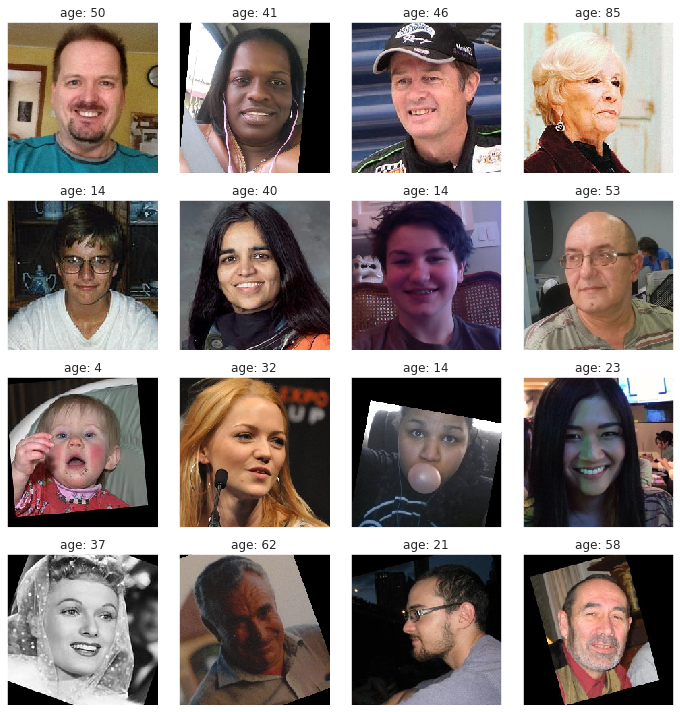

In [9]:
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('age: ' + str(target[i]))

## Вывод

- датафрейм состоит из двух столбцов: фотографий людей и значений их возраста. Пропущенных данных нет;
- на большинстве фотографий изображены молодые люди (75% - до 41 года). Среднее значение - 31 год. Даты, кратные десяти, встречаются чаще;
- попадаются черно-белые и затемненные фотографии. Некоторые заключены в рамки разной толщины;
- вероятно, модель будет лучше предсказывать возраст молодых и склоняться к круглым датам.

# Обучение модели

Отношение обучающей выборки к тестовой составляет 75:25.

На тренировочной выборке применена аугментация в виде вертикального и горизонтального отражения.

При построении модели выбрана архитектура **ResNet50** с добавлением слоев **GlobalAveragePooling2D** и **Dense**. В последнем слое применена активация **ReLU**. Для оптимизации работы модели использован алгоритм **Adam** с шагом 0.0001.

Количество эпох = 10.

В качестве функции потерь взята среднеквадратическая ошибка (**MSE**), а в качестве метрики - средняя абсолютная ошибка (**MAE**).

---

Код обучения модели:

```python
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

labels = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25, vertical_flip = True, 
                                       horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
                                                dataframe=labels,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='training',
                                                seed=12345) 
    
    return train_gen_flow


def load_test(path):

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
                                                dataframe=labels,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='raw',
                                                subset='validation',
                                                seed=12345) 
    
    return test_gen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
```

---

Результат работы кода:

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 49s - loss: 262.4142 - mae: 11.8299 - val_loss: 687.7462 - val_mae: 21.2621
Epoch 2/10
178/178 - 39s - loss: 104.9292 - mae: 7.7474 - val_loss: 452.1947 - val_mae: 16.0952
Epoch 3/10
178/178 - 38s - loss: 79.4583 - mae: 6.7361 - val_loss: 285.9697 - val_mae: 12.5722
Epoch 4/10
178/178 - 39s - loss: 65.2532 - mae: 6.1779 - val_loss: 117.7711 - val_mae: 8.1214
Epoch 5/10
178/178 - 39s - loss: 55.3668 - mae: 5.6316 - val_loss: 85.8928 - val_mae: 6.9514
Epoch 6/10
178/178 - 39s - loss: 44.7617 - mae: 5.1246 - val_loss: 101.8478 - val_mae: 7.7813
Epoch 7/10
178/178 - 39s - loss: 38.3055 - mae: 4.7019 - val_loss: 76.0293 - val_mae: 6.4177
Epoch 8/10
178/178 - 39s - loss: 34.4104 - mae: 4.4524 - val_loss: 79.2165 - val_mae: 6.6300
Epoch 9/10
178/178 - 38s - loss: 30.0656 - mae: 4.1776 - val_loss: 75.3631 - val_mae: 6.6492
Epoch 10/10
178/178 - 39s - loss: 27.7038 - mae: 4.0074 - val_loss: 74.6798 - val_mae: 6.4767
60/60 - 10s - loss: 74.6798 - mae: 6.4767
Test MAE: 6.4767
```

## Вывод

На обучающей выборке значение MAE составило 4,01, на тестовой - 6,48. Требуемый результат достигнут.

# Анализ обученной модели

В работе построена модель, определяющая приблизительный возраст человека по фотографии. 

Проанализирован исходный датафрейм, состоящий из 7 591 фотографии людей и значений их возраста. Фотографии имеют разное качество: некоторые из них черно-белые или затемненные. Часть заключена в рамки разной толщины. Встречаются повернутые изображения.

На большинстве фотографий изображены молодые люди (75% - до 41 года). Среднее значение - 31 год. Чаще встречаются даты, кратные десяти.

При построении модели была выбрана архитектура **ResNet50** с добавлением слоев **GlobalAveragePooling2D** и **Dense**. В последнем слое применена активация **ReLU**. Для оптимизации использован алгоритм **Adam** с шагом 0.0001.

Отношение обучающей выборки к тестовой составляет 75:25. На обучающей выборке осуществлена аугментация в виде вертикального и горизонтального отражения.

В качестве функции потерь использована среднеквадратическая ошибка (**MSE**), а в качестве метрики - средняя абсолютная ошибка (**MAE**).

На обучающей выборке значение MAE составило 4,01, на тестовой - 6,48, что превосходит требуемое значение.